In [11]:
from torchvision import models
import torchvision.transforms as T
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

2022-05-02 21:03:19 URL:https://uc442689c85105bc3ff763b58031.dl.dropboxusercontent.com/cd/0/inline/BkjxzO8KgPHSSW1lTelb_wFYpSdv_DeQ5HVqedRSbSyEgGEz2-5Ev2kuAL_T6XQhA1-aLDE9tKTf9mPliU_MGfmpgWc74wUyBHhXxuxE5gWXj9HKmjIH-2qeSAL5pCwZKrK4hUXmcC8pyEsGhU1luy38NekAwzDOLDGARnVBKo4VPQ/file [101615/101615] -> "input_img.png" [1]


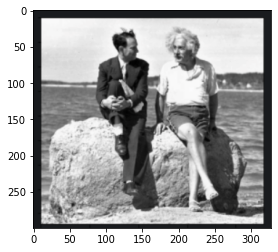

In [27]:
!wget -nv 'https://www.dropbox.com/s/fwc29xkl0b75uw0/Einstein2.png?dl=0' -O input_img.png

_img = Image.open('./input_img.png').convert('RGB')
plt.imshow(_img) 
plt.show()

In [21]:

dlv3 = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
n_classes = 21 
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(n_classes)])[:, None] * palette

In [22]:
def infer_segment_color(img):
  

  [r,g,b] = 3 * [np.zeros_like(img).astype(np.uint8)]
  
  for i in range(n_classes):
    idx = (img == i)
    r[idx],  g[idx],  b[idx] =  colors[i, 0],  colors[i, 1], colors[i, 2]
  rgb = np.stack([r, g, b], axis=2)
  
  return rgb

In [23]:
def generate_mask(img):

  transform = T.Compose([T.Resize(640),
                     T.ToTensor(),
                     T.Normalize(mean = [0.485, 0.456, 0.406],  std = [0.229, 0.224, 0.225])])

  output = dlv3(transform(img).unsqueeze(0))['out']
  mask = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
  mask = infer_segment_color(mask)

  return mask


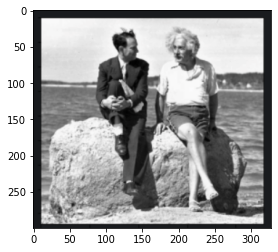

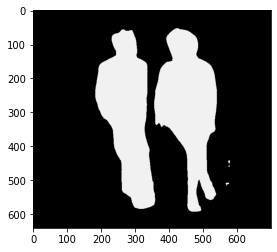

In [28]:
mask = generate_mask(_img)

plt.imshow(_img)
plt.show()

plt.imshow(mask)
plt.show()

In [17]:
def train_model(model, criterion, dataloaders, optimizer, metrics, bpath,
                num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            # Iterate over data.
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model